In [ ]:
from google.colab import drive
from google.colab import output

In [ ]:
!pip install qiskit
output.clear() #clear the cell output

In [ ]:
from qiskit import *

In [ ]:
#--------------------------------------------------
# INCREMENT CIRC FOR 3-BIT STATE REGISTER
#--------------------------------------------------
def increment_op(circuit):
    qr = circuit.qubits
    
    circuit.mct([qr[0],qr[1],qr[2]],qr[3],None,mode='noancilla')
    circuit.ccx(qr[0],qr[1],qr[2])
    circuit.cx(qr[0],qr[1])

    return circuit

In [ ]:
#--------------------------------------------------
# DECREMENT CIRC FOR 3-BIT STATE REGISTER
#--------------------------------------------------
def decrement_op(circuit):
    qr = circuit.qubits

    circuit.barrier()
    circuit.x([qr[0], qr[1], qr[2]])

    circuit.mct([qr[0],qr[1],qr[2]],qr[3],None,mode='noancilla')
    circuit.ccx(qr[0],qr[1],qr[2])
    circuit.cx(qr[0],qr[1])

    circuit.barrier()  
    circuit.x([qr[0], qr[1], qr[2]])
       
    return circuit

In [ ]:
def quantum_walk_step(circuit):
    #increment circuit
    qr_incr = QuantumRegister(4)
    increment_circ = QuantumCircuit(qr_incr, name='increment')
    increment_op(increment_circ)
    increment_inst = increment_circ.to_instruction()

    #decrement circuit
    qr_decr = QuantumRegister(4)
    decrement_circ = QuantumCircuit(qr_decr, name='decrement')
    decrement_op(decrement_circ)
    decrement_inst = decrement_circ.to_instruction()

    circuit.h(qr[0]) #coin
    circuit.append(increment_inst, qr[0:4]) # adder
    circuit.append(decrement_inst, qr[0:4]) # decrementer
    
    return circuit   

In [ ]:
# construct the circuit
# just for showing

qr = QuantumRegister(4)
cr = ClassicalRegister(3)
circuit = QuantumCircuit(qr, cr)

quantum_walk_step(circuit)

circuit.draw()

┌───┐┌────────────┐┌────────────┐
q0_0: ┤ H ├┤0           ├┤0           ├
      └───┘│            ││            │
q0_1: ─────┤1           ├┤1           ├
           │  increment ││  decrement │
q0_2: ─────┤2           ├┤2           ├
           │            ││            │
q0_3: ─────┤3           ├┤3           ├
           └────────────┘└────────────┘
c0: 3/═════════════════════════════════

In [ ]:
# the decomposed version 
decomposed = circuit.decompose()
decomposed.draw()

┌─────────┐                ░ ┌───┐                ░ ┌───┐
q0_0: ┤ U2(0,π) ├──■────■────■───░─┤ X ├──■────■────■───░─┤ X ├
      └─────────┘  │    │  ┌─┴─┐ ░ ├───┤  │    │  ┌─┴─┐ ░ ├───┤
q0_1: ─────────────■────■──┤ X ├─░─┤ X ├──■────■──┤ X ├─░─┤ X ├
                   │  ┌─┴─┐└───┘ ░ ├───┤  │  ┌─┴─┐└───┘ ░ ├───┤
q0_2: ─────────────■──┤ X ├──────░─┤ X ├──■──┤ X ├──────░─┤ X ├
                 ┌─┴─┐└───┘      ░ └───┘┌─┴─┐└───┘      ░ └───┘
q0_3: ───────────┤ X ├───────────░──────┤ X ├───────────░──────
                 └───┘           ░      └───┘           ░      
c0: 3/═════════════════════════════════════════════════════════

In [ ]:
#------------------------------
# EXPERIMENT
#------------------------------

#construct the circuit
qr = QuantumRegister(4)
cr = ClassicalRegister(3)
circuit = QuantumCircuit(qr, cr)

# perform a walk of n-steps 
STEPS = 1

for i in range(0, STEPS):
  quantum_walk_step(circuit)

# measure only at the end of the circuit 
circuit.measure([qr[1],qr[2], qr[3]], cr)

#simulate the circuit
simulator = Aer.get_backend('qasm_simulator')
result_simulation = execute(circuit, simulator).result()

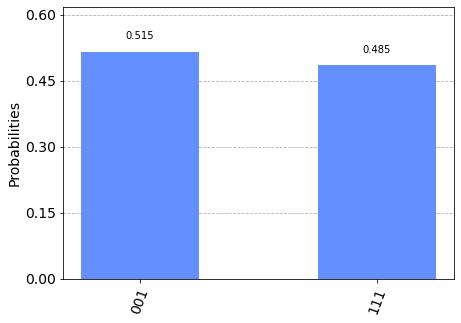

In [ ]:
from qiskit.tools.visualization import plot_histogram, plot_circuit_layout
plot_histogram(result_simulation.get_counts(circuit))

In [ ]:
from qiskit import IBMQ

ACCOUNT_API_STRING = ''
PROVIDER = 'ibm-q'
BACKEND = 'ibmq_athens'


IBMQ.save_account(ACCOUNT_API_STRING)
IBMQ.load_account()
provider = IBMQ.get_provider(PROVIDER)
qcomp = provider.get_backend(BACKEND)

In [ ]:
from qiskit.tools.monitor import job_monitor

job = execute(circuit, backend=qcomp)
job_monitor(job)

Job Status: job has successfully run


In [ ]:
# store job results
result = job.result()

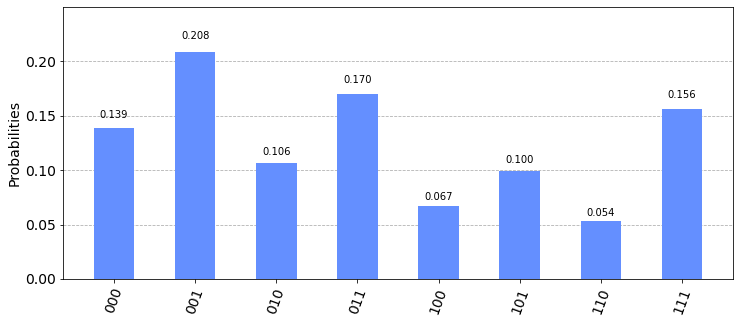

In [ ]:
plot_histogram(result.get_counts(circuit), figsize=(12, 5))

In [ ]:
#------------------------------
# RESULTS CHART
#------------------------------
import pandas as pd
from time import strftime, gmtime

rsim = result_simulation.get_counts()
real = result.get_counts()

SHOTS = 1024
labels = ['000', '001', '010', '011', '100', '101', '110', '111']

rsim_dict = {}
real_dict = {}
for l in labels:
  rsim_dict[l] = rsim.get(l) / SHOTS if l in rsim.keys() else 0
  real_dict[l] = real.get(l) / SHOTS if l in real.keys() else 0

rsim_df = pd.DataFrame.from_dict(rsim_dict.items())
real_df = pd.DataFrame.from_dict(real_dict.items())

# assign different labels
rsim_df.columns = ['label', 'prob_simulation']
real_df.columns = ['label', 'prob_real']

# join simul and real result on labels
results = pd.merge(rsim_df, real_df, on='label')

timestamp = strftime("%d-%m-%Y-%H:%M:%S", gmtime())
results.to_csv("CQW-experiment-{}.csv".format(timestamp))
results

,label,prob_simulation,prob_real
0,000,0.000000,0.138672
1,001,0.514648,0.208008
2,010,0.000000,0.106445
3,011,0.000000,0.169922
4,100,0.000000,0.067383
5,101,0.000000,0.099609
6,110,0.000000,0.053711
7,111,0.485352,0.156250


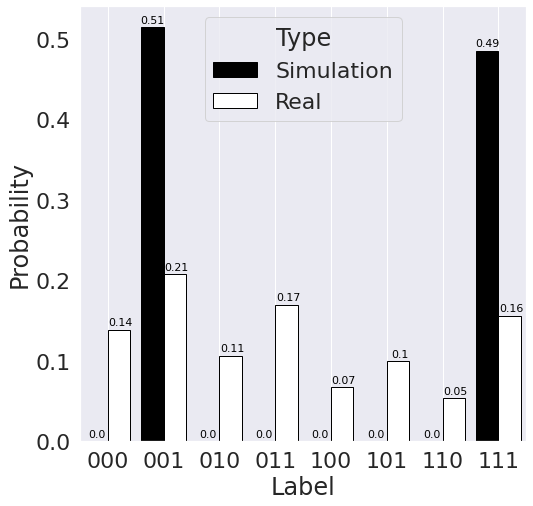

In [ ]:
#------------------------------
# COMPARISON REAL AND SIM
#------------------------------
import seaborn as sns
from matplotlib import pyplot as plt
import numpy
sns.set(font_scale=2)  
plt.figure(figsize=(8, 8)) # width and height in inches

df = pd.DataFrame({
    'Label': list(results.label),
    'Simulation': list(results.prob_simulation),
    'Real': list(results.prob_real)
})

tidy = df.melt(id_vars='Label').rename(columns=str.title)
tidy.columns = ['Label', 'Type', 'Probability']
ax = sns.barplot(x='Label', y='Probability', hue='Type', data=tidy, palette=['black', 'white'], edgecolor='black')

for index, row in tidy.iterrows():
    if row.Type == 'Real': 
      ax.text(index - 7.77 ,row.Probability+0.005, round(row.Probability, 2), color='black', ha="center", fontsize=11)
    if row.Type == 'Simulation': 
      ax.text(index - 0.2, row.Probability+0.005, round(row.Probability, 2), color='black', ha="center", fontsize=11)
#ax.patch.set_edgecolor('black') 

plt.grid(axis='both')
plt.savefig('results_CQW.png', format='png', transparent=True)